<a href="https://colab.research.google.com/github/Sank3t-Pand3y/MachineLearning_Projects/blob/main/Evaluating_k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.datasets import make_classification
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm

## Clustering Evaluation function

We'll define a function for evaluating the clustering models we'll be building.
We'll include silhouette scores and the Davies-Bouldin index, plus generate a plot displaying the silhouette scores

In [2]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=''):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.

    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec

    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label) / n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = color_dict[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax.set_title(f'Silhouette Score for {title_suffix} \n' +
                 f'Average Silhouette: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]

    ax.set_yticks([])


## Create synthetic data with four blobs to experiment with k-means clustering
Here we'll make some synthetic data consisting of slightly overlapping blobs, then run and evaluate k-means with k=4 clusters.


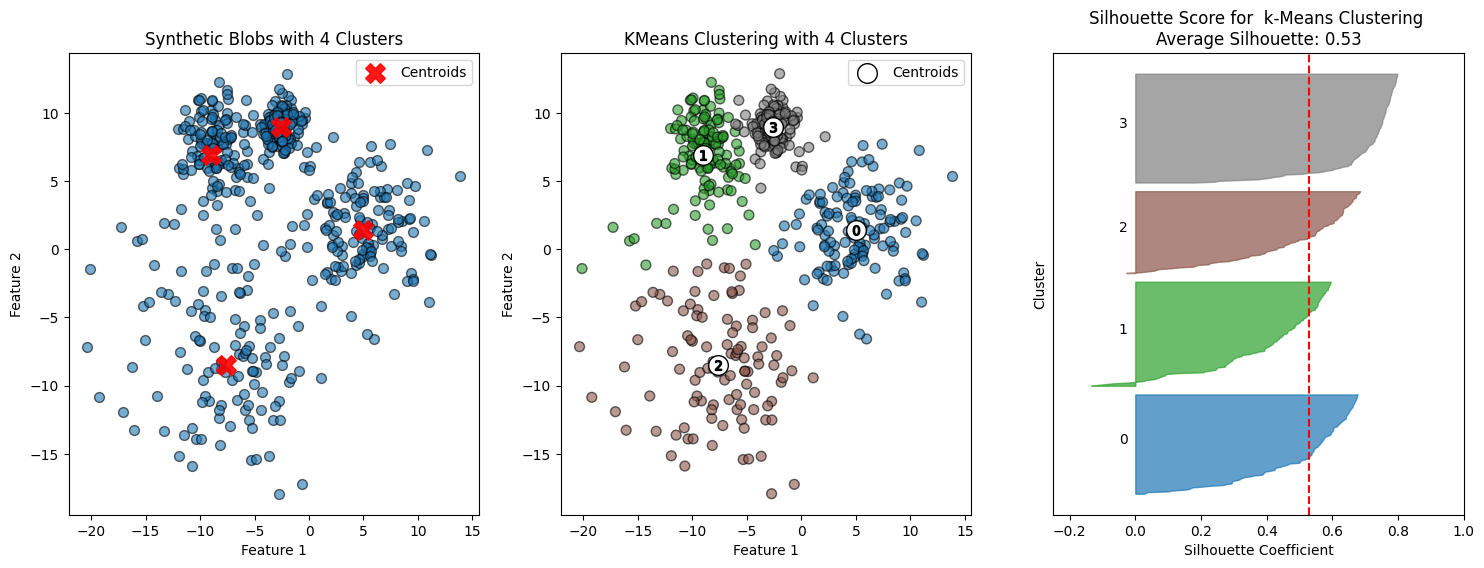

In [3]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[1.0, 3, 5, 2], random_state=42)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot the blobs
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor='k')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', alpha=0.9, label='Centroids')
plt.title(f'Synthetic Blobs with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')

# Label the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
    label='Centroids'
)
# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix=' k-Means Clustering')
plt.show()


Each point in a silhouette plot has a silhouette score ranging from -1 to 1. A high silhouette score indicates the data point is much more similar to its own cluster than its neighboring clusters. A score near 0 implies the point is at or near the decision boundary between two clusters. A negative score means the point might have been assigned to the wrong cluster. We'll take a closer look at the silhoutte plot later.

The clustering result is quite plausible, particularly because we already know that there are four blobs in the synthetic data. Practically hoeever, we would not have such information.


## Cluster Stability
How do the results change when K-means is run using different initial centroid seeds?

To assess stability, we can measure *inertia* and repeatedly vary the random initialization of cluster centers to observe the impact of having different intitial centroid locations.

Inertia measures the compactness of clusters in K-means. It is defined as the sum of squared distances between each data point and its cluster centroid. Lower inertia values indicate more compact clusters and a potentially better clustering outcome. However, inertia tends to decrease as the number of clusters increases, so it's important to interpret it alongside other metrics.

To evaluate the stability of clustering, running k-means multiple times with different initial centroids by not fixing the random state helps determine if the algorithm consistently produces similar cluster assignments and inertia scores. Consistent inertia across runs suggests a stable solution that is less dependent on initial centroid positions.


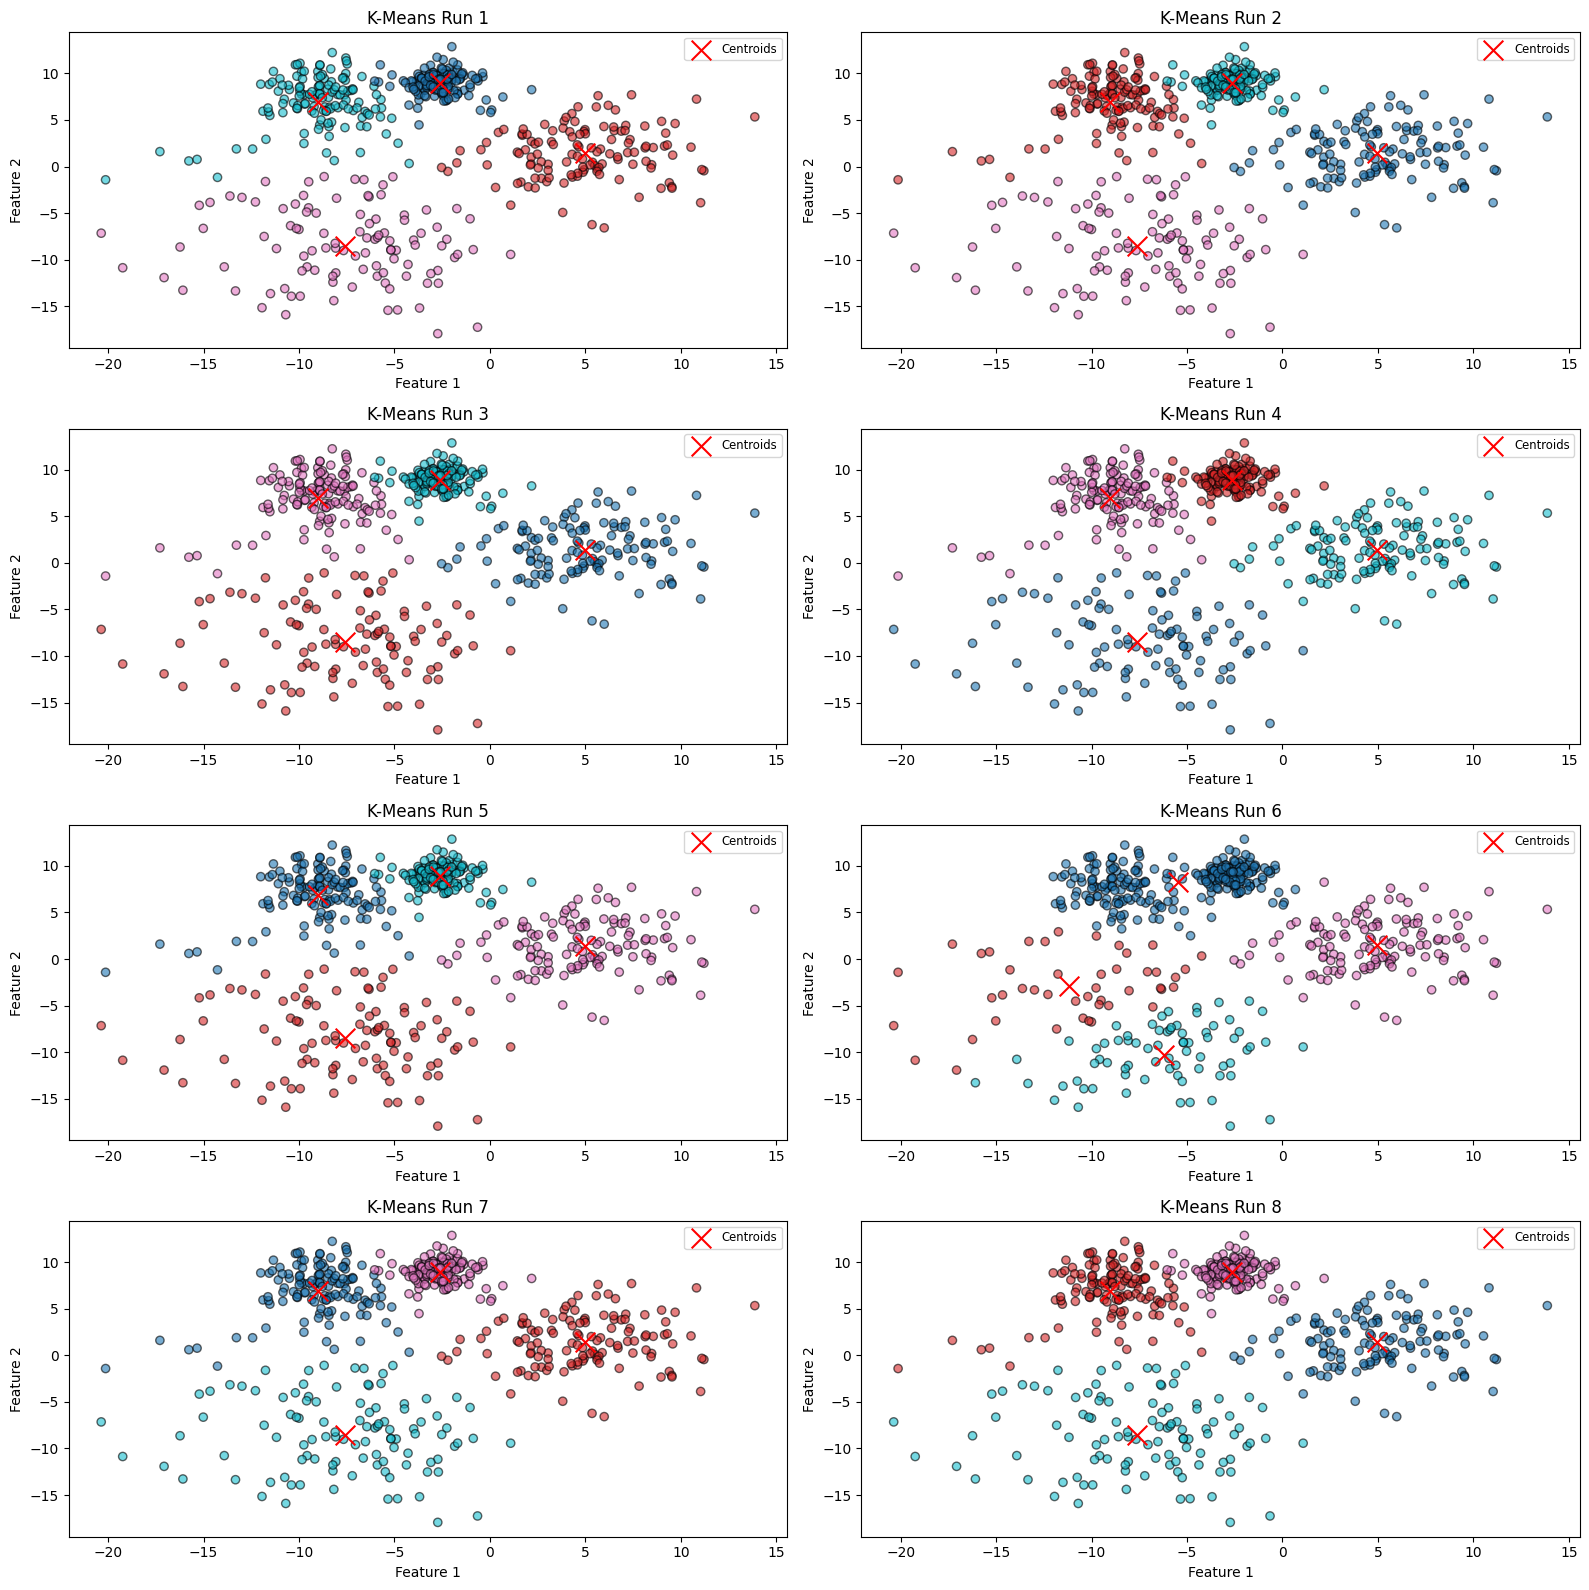

Run 1: Inertia=7633.51
Run 2: Inertia=7633.68
Run 3: Inertia=7633.51
Run 4: Inertia=7633.51
Run 5: Inertia=7633.51
Run 6: Inertia=8556.71
Run 7: Inertia=7633.51
Run 8: Inertia=7633.51


In [4]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2 # Number of columns
n_rows = -(-n_runs // n_cols) # Ceil division to determine rows
plt.figure(figsize=(16, 16)) # Adjust the figure size for better visualization

# Run K-Means multiple times with different random states
for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=None)  # Use the default `n_init`
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

    # Plot the clustering result
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='tab10', alpha=0.6, edgecolor='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, marker='x', label='Centroids')
    plt.title(f'K-Means Run {i + 1}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
    print(f'Run {i}: Inertia={inertia:.2f}')

As demonstrated by the clustering results, the cluster assignments vary between runs when using different initial centroid seeds. Additionally, the inertia values show inconsistency, indicating that the clustering process is sensitive to the initial placement of centroids. This inertial inconsistency implies an less reliable result.
